# Plot qPCR of stability of exported RNA in blood

# Introduction

## Imports

In [1]:
import sys
import os
import time

import numpy as np
import scipy
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

## Set output parameters

In [2]:
# Set pandas display options
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Set plot display options
FONTSIZE = 8  # universal fontsize
params = {
    'font.size': FONTSIZE,
    'axes.titlesize': FONTSIZE,
    'axes.labelsize': FONTSIZE,
    'legend.fontsize': FONTSIZE,
    'xtick.labelsize': FONTSIZE,
    'ytick.labelsize': FONTSIZE,
    'font.family': "Helvetica",
    'mathtext.fontset': 'custom',
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 300
   }
mpl.rcParams.update(params)
sns.set_style("ticks", {'axes.grid' : False})

# Set plot output options
output_dir = "outs/qPCR_stability_blood"
output_suffix = ""
output_formats = [".png", ".pdf"]

mpl.rc('savefig', dpi=300)

# Define convenience function for saving figures

savefig = True
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0.1}

def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    if savefig:
        for output_format in output_formats:
            fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

In [3]:
# Report plot parameters
sns.plotting_context()

{'font.size': 8.0,
 'axes.labelsize': 8.0,
 'axes.titlesize': 8.0,
 'xtick.labelsize': 8.0,
 'ytick.labelsize': 8.0,
 'legend.fontsize': 8.0,
 'legend.title_fontsize': None,
 'axes.linewidth': 0.8,
 'grid.linewidth': 0.8,
 'lines.linewidth': 1.5,
 'lines.markersize': 6.0,
 'patch.linewidth': 1.0,
 'xtick.major.width': 0.8,
 'ytick.major.width': 0.8,
 'xtick.minor.width': 0.6,
 'ytick.minor.width': 0.6,
 'xtick.major.size': 3.5,
 'ytick.major.size': 3.5,
 'xtick.minor.size': 2.0,
 'ytick.minor.size': 2.0}

# Load data

## Load qPCR data

In [4]:
infile = "../preprocessed_data/qPCR_data/qPCR_stability_blood_Cq.csv"

cq_raw = pd.read_csv(infile, header=0)

cq_raw = cq_raw.set_index("Sample")

print(cq_raw.shape)
cq_raw.head()

(56, 11)


,Well,Fluor,Target,Content,Cq,Cq Mean,Cq Std. Dev,Starting Quantity (SQ),Log Starting Quantity,SQ Mean,SQ Std. Dev
Sample,,,,,,,,,,,
24-1,A01,SYBR,mCherry,Unkn-01,24.397387,24.180357,0.191847,2072.255424,3.316443,2423.762559,312.243040
24-2,A02,SYBR,mCherry,Unkn-02,23.995189,23.628177,0.317984,2740.825831,3.437881,3592.909938,738.401493
24-3,A03,SYBR,mCherry,Unkn-03,23.076364,23.045294,0.076593,5191.688355,3.715309,5310.114831,286.461565
24-4,A04,SYBR,mCherry,Unkn-04,23.122449,22.824029,0.300629,5027.983197,3.701394,6277.814385,1307.927210
24-5,A05,SYBR,mCherry,Unkn-05,22.950310,22.992649,0.041029,5667.206630,3.753369,5504.314857,157.219101


In [5]:
# Load metadata (includes sample names)
infile = "../preprocessed_data/qPCR_data/qPCR_stability_blood_metadata.csv"
metadata = pd.read_csv(infile, index_col=0, header=0)
metadata = metadata.reset_index()
print(metadata.shape)
metadata.head()

(16, 4)


,Sample,Media,Spike-in,Time (h)
0,24-1,Blood,EPN24-MCP,0.00
1,24-2,Blood,EPN24-MCP,0.25
2,24-3,Blood,EPN24-MCP,1.00
3,24-4,Blood,EPN24-MCP,4.00
4,24-5,Blood,EPN24-MCP,24.00


# Preprocess data

## Calculate total starting molecules

In [6]:
# Calculate normalization for input volume
DILUTION_FACTORS = (15/5) * (61/10) * (20/1)

In [7]:
# Back-calculate input RNA molecules, given <100% efficiency of extraction, DNase, RT, as measured based on RNA standard

PROTOCOL_EFFICIENCY = 0.005957820738  # Efficiency of extraction, DNase, RT

In [8]:
# Calculate total RNA molecules in supernatant
cq_raw["RNA molecules"] = cq_raw["Starting Quantity (SQ)"] * DILUTION_FACTORS * (1/PROTOCOL_EFFICIENCY)
cq_raw["RNA molecules Mean"] = cq_raw["SQ Mean"] * DILUTION_FACTORS * (1/PROTOCOL_EFFICIENCY)
cq_raw["RNA molecules STD"] = cq_raw["SQ Std. Dev"] * DILUTION_FACTORS * (1/PROTOCOL_EFFICIENCY)

## Summarize replicates

In [9]:
groups = cq_raw.groupby(["Sample"])  # group samples by origin

summary = pd.DataFrame()

summary["mean SQ"] = groups["Starting Quantity (SQ)"].mean()  # Calculate mean over replicates
summary["std SQ"] = groups["Starting Quantity (SQ)"].std()  # Calculate mean over replicates

summary["RNA molecules"] = groups["RNA molecules"].mean()
summary["RNA molecules STD"] = groups["RNA molecules STD"].mean()

summary

,mean SQ,std SQ,RNA molecules,RNA molecules STD
Sample,,,,
24-1,2423.762559,312.243040,1.488962e+08,1.918167e+07
24-10,41531.152937,334.458094,2.551336e+09,2.054638e+07
24-11,485473.867367,157943.954536,2.982356e+10,9.702791e+09
24-12,515.464440,115.913100,3.166594e+07,7.120757e+06
24-13,748.581317,114.975313,4.598674e+07,7.063147e+06
24-14,161.476761,10.262550,9.919817e+06,6.304475e+05
24-15,122.516771,12.196818,7.526433e+06,7.492732e+05
24-2,3592.909938,738.401493,2.207191e+08,4.536138e+07
24-3,5310.114831,286.461565,3.262102e+08,1.759787e+07


## Calculate relative abundance (compared with appropriate references)

In [10]:
# Initialize columns

summary["RNA molecules relative to reference"] = np.nan
summary["RNA molecules relative to reference STD"] = np.nan

cq_raw["RNA molecules relative to reference"] = np.nan
cq_raw["RNA molecules relative to reference STD"] = np.nan

In [11]:
# Calculate RNA molecules relative to reference

# EPN24-MCP in blood

ref = summary.loc["24-1", "RNA molecules"]  # set reference value
samples = ["24-1", "24-2", "24-3", "24-4", "24-5"]  # samples that use this reference value

summary.loc[samples, "RNA molecules relative to reference"] = summary.loc[samples, "RNA molecules"] / ref
summary.loc[samples, "RNA molecules relative to reference STD"] = summary.loc[samples, "RNA molecules STD"] / ref

# Gag-MCP in blood

ref = summary.loc["24-6", "RNA molecules"]  # set reference value
samples = ["24-6", "24-7", "24-8", "24-9", "24-10"]  # samples that use this reference value

summary.loc[samples, "RNA molecules relative to reference"] = summary.loc[samples, "RNA molecules"] / ref
summary.loc[samples, "RNA molecules relative to reference STD"] = summary.loc[samples, "RNA molecules STD"] / ref

# Free mRNA in blood

ref = summary.loc["24-11", "RNA molecules"]  # set reference value
samples = ["24-11", "24-12", "24-13", "24-14", "24-15"]  # samples that use this reference value

summary.loc[samples, "RNA molecules relative to reference"] = summary.loc[samples, "RNA molecules"] / ref
summary.loc[samples, "RNA molecules relative to reference STD"] = summary.loc[samples, "RNA molecules STD"] / ref

In [12]:
# Repeat for raw Cq values

# Calculate RNA molecules relative to reference

# EPN24-MCP in blood

ref = summary.loc["24-1", "RNA molecules"]  # set reference value
samples = ["24-1", "24-2", "24-3", "24-4", "24-5"]  # samples that use this reference value

cq_raw.loc[samples, "RNA molecules relative to reference"] = cq_raw.loc[samples, "RNA molecules"] / ref
cq_raw.loc[samples, "RNA molecules relative to reference STD"] = cq_raw.loc[samples, "RNA molecules STD"] / ref

# Gag-MCP in blood

ref = summary.loc["24-6", "RNA molecules"]  # set reference value
samples = ["24-6", "24-7", "24-8", "24-9", "24-10"]  # samples that use this reference value

cq_raw.loc[samples, "RNA molecules relative to reference"] = cq_raw.loc[samples, "RNA molecules"] / ref
cq_raw.loc[samples, "RNA molecules relative to reference STD"] = cq_raw.loc[samples, "RNA molecules STD"] / ref

# Free mRNA in blood

ref = summary.loc["24-11", "RNA molecules"]  # set reference value
samples = ["24-11", "24-12", "24-13", "24-14", "24-15"]  # samples that use this reference value

cq_raw.loc[samples, "RNA molecules relative to reference"] = cq_raw.loc[samples, "RNA molecules"] / ref
cq_raw.loc[samples, "RNA molecules relative to reference STD"] = cq_raw.loc[samples, "RNA molecules STD"] / ref

cq_raw = cq_raw.reset_index()

In [13]:
# Convert to percentage

summary["RNA molecules relative to reference %"] = summary["RNA molecules relative to reference"] * 100
summary["RNA molecules relative to reference STD %"] = summary["RNA molecules relative to reference STD"] * 100

cq_raw["RNA molecules relative to reference %"] = cq_raw["RNA molecules relative to reference"] * 100
cq_raw["RNA molecules relative to reference STD %"] = cq_raw["RNA molecules relative to reference STD"] * 100

## Censor by lower limit of quantification

In [14]:
# Lower limit of quantification is set based on maximum signal from blank sample (blood without spike-in RNA).

LOD = cq_raw.set_index("Sample").loc["24-31", "RNA molecules"].max()

print("Lower limit of quantification:", LOD)

Lower limit of quantification: 1075175.0400651277


In [15]:
# Substitute LOD for values below LOD

cq_raw["RNA molecules censored"] = cq_raw["RNA molecules"]
cq_raw.loc[cq_raw["RNA molecules"] < LOD, "RNA molecules censored"] = LOD

summary["RNA molecules censored"] = summary["RNA molecules"]
summary.loc[summary["RNA molecules"] < LOD, "RNA molecules censored"] = LOD

## Calculate relative abundance after censoring

In [16]:
# Initialize columns

summary["RNA molecules censored relative to reference"] = np.nan

cq_raw["RNA molecules censored relative to reference"] = np.nan

In [17]:
# Calculate RNA molecules censored relative to reference

# EPN24-MCP in blood

ref = summary.loc["24-1", "RNA molecules censored"]  # set reference value
samples = ["24-1", "24-2", "24-3", "24-4", "24-5"]  # samples that use this reference value

summary.loc[samples, "RNA molecules censored relative to reference"] = summary.loc[samples, "RNA molecules censored"] / ref

# Gag-MCP in blood

ref = summary.loc["24-6", "RNA molecules censored"]  # set reference value
samples = ["24-6", "24-7", "24-8", "24-9", "24-10"]  # samples that use this reference value

summary.loc[samples, "RNA molecules censored relative to reference"] = summary.loc[samples, "RNA molecules censored"] / ref

# Free mRNA in blood

ref = summary.loc["24-11", "RNA molecules censored"]  # set reference value
samples = ["24-11", "24-12", "24-13", "24-14", "24-15"]  # samples that use this reference value

summary.loc[samples, "RNA molecules censored relative to reference"] = summary.loc[samples, "RNA molecules censored"] / ref

In [18]:
# Repeat for raw Cq values

cq_raw = cq_raw.set_index("Sample")

# Calculate RNA molecules censored relative to reference

# EPN24-MCP in blood

ref = summary.loc["24-1", "RNA molecules censored"]  # set reference value
samples = ["24-1", "24-2", "24-3", "24-4", "24-5"]  # samples that use this reference value

cq_raw.loc[samples, "RNA molecules censored relative to reference"] = cq_raw.loc[samples, "RNA molecules censored"] / ref

# Gag-MCP in blood

ref = summary.loc["24-6", "RNA molecules censored"]  # set reference value
samples = ["24-6", "24-7", "24-8", "24-9", "24-10"]  # samples that use this reference value

cq_raw.loc[samples, "RNA molecules censored relative to reference"] = cq_raw.loc[samples, "RNA molecules censored"] / ref

# Free mRNA in blood

ref = summary.loc["24-11", "RNA molecules censored"]  # set reference value
samples = ["24-11", "24-12", "24-13", "24-14", "24-15"]  # samples that use this reference value

cq_raw.loc[samples, "RNA molecules censored relative to reference"] = cq_raw.loc[samples, "RNA molecules censored"] / ref

cq_raw = cq_raw.reset_index()

In [19]:
# Convert to percentage

summary["RNA molecules censored relative to reference %"] = summary["RNA molecules censored relative to reference"] * 100

cq_raw["RNA molecules censored relative to reference %"] = cq_raw["RNA molecules censored relative to reference"] * 100

# Visualize RNA stability in blood

## EPN24-MCP 

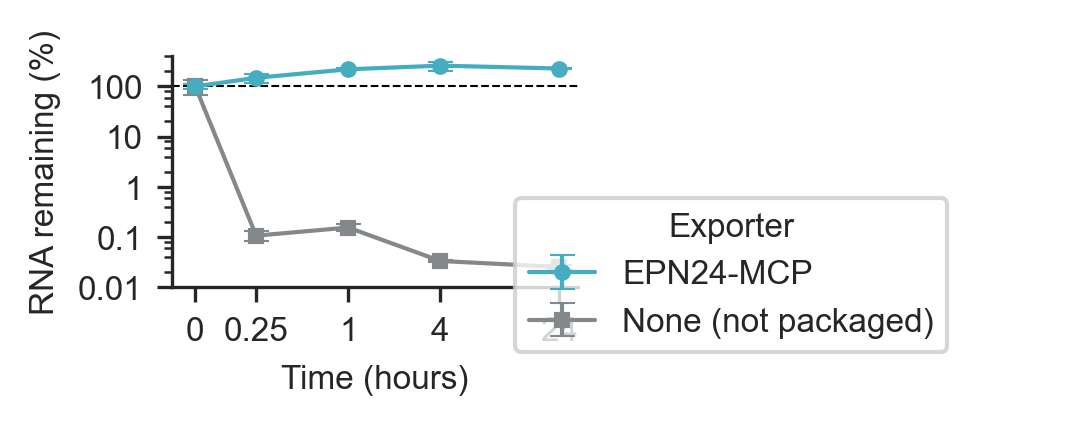

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(1.75, 1))

ax.set_yscale("log")
ax.set_xscale("log")

# EPN24-MCP

index_ordered = ["24-1", "24-2", "24-3", "24-4", "24-5"]
summary_subset = summary.loc[index_ordered]
summary_subset["Time"] = [0.1, 0.25, 1, 4, 24]

x = summary_subset["Time"]
y = summary_subset["RNA molecules censored relative to reference %"]
yerr = summary_subset["RNA molecules relative to reference STD %"]

ax.errorbar(x=x,
            y=y,
            yerr=yerr,
            color="#44adbf",
            marker=".",
            capsize=3,
            capthick=0.5,
            lw=1,
            label="EPN24-MCP",
            zorder=3)

# Free mRNA

index_ordered = ["24-11", "24-12", "24-13", "24-14", "24-15"]
summary_subset = summary.loc[index_ordered]
summary_subset["Time"] = [0.1, 0.25, 1, 4, 24]

x = summary_subset["Time"]
y = summary_subset["RNA molecules censored relative to reference %"]
yerr = summary_subset["RNA molecules relative to reference STD %"]

ax.errorbar(x=x,
            y=y,
            yerr=yerr,
            color="#83888a",
            marker="s",
            markersize=3,
            capsize=3,
            capthick=0.5,
            lw=1,
            label="None (not packaged)",
            zorder=1)

ax.set_xlim(0.07, 32)
ax.set_ylim(0.01, 400)

locmaj = mpl.ticker.LogLocator(base=10,numticks=12) 
ax.yaxis.set_major_locator(locmaj)

locmin = mpl.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

ax.set_xticks([0.1, 0.25, 1, 4, 24])
ax.tick_params(which="minor", axis="x", size=0)
ax.set_xticklabels([0, 0.25, 1, 4, 24])

ax.set_xlabel("Time (hours)")
ax.set_ylabel("RNA remaining (%)")
ax.set_yticklabels(["", "0.01", "0.1", "1", "10", "100"])

fig.legend(loc="center left", bbox_to_anchor=(0.95, 0.5), title="Exporter")

LOD = summary.loc["24-31", "RNA molecules censored relative to reference %"].max()
ax.axhline(LOD, ls="--", color="k", lw=0.5, zorder=-1)

ax.axhline(100, ls="--", color="k", lw=0.5, zorder=-1)

sns.despine()

save_figure(fig, "stability_blood_EPN24MCP_37C_censored")

## Gag-MCP

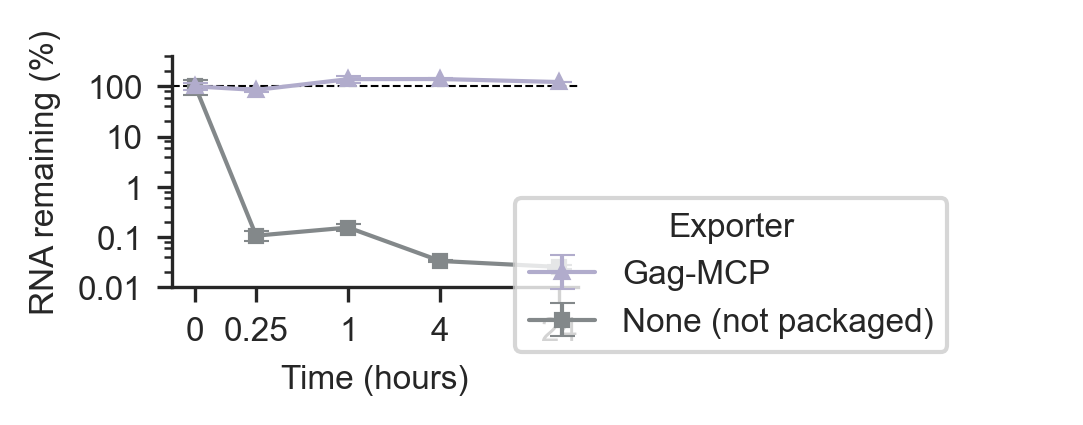

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(1.75, 1))

ax.set_yscale("log")
ax.set_xscale("log")

# Gag-MCP

index_ordered = ["24-6", "24-7", "24-8", "24-9", "24-10"]
summary_subset = summary.loc[index_ordered]
summary_subset["Time"] = [0.1, 0.25, 1, 4, 24]

x = summary_subset["Time"]
y = summary_subset["RNA molecules censored relative to reference %"]
yerr = summary_subset["RNA molecules relative to reference STD %"]

ax.errorbar(x=x,
            y=y,
            yerr=yerr,
            color="#b1accc",
            marker="^",
            markersize=3,
            capsize=3,
            capthick=0.5,
            lw=1,
            label="Gag-MCP",
            zorder=2)

# Free mRNA

index_ordered = ["24-11", "24-12", "24-13", "24-14", "24-15"]
summary_subset = summary.loc[index_ordered]
summary_subset["Time"] = [0.1, 0.25, 1, 4, 24]

x = summary_subset["Time"]
y = summary_subset["RNA molecules censored relative to reference %"]
yerr = summary_subset["RNA molecules relative to reference STD %"]

ax.errorbar(x=x,
            y=y,
            yerr=yerr,
            color="#83888a",
            marker="s",
            markersize=3,
            capsize=3,
            capthick=0.5,
            lw=1,
            label="None (not packaged)",
            zorder=1)

ax.set_xlim(0.07, 32)
ax.set_ylim(0.01, 400)

locmaj = mpl.ticker.LogLocator(base=10,numticks=12) 
ax.yaxis.set_major_locator(locmaj)

locmin = mpl.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

ax.set_xticks([0.1, 0.25, 1, 4, 24])
ax.tick_params(which="minor", axis="x", size=0)
ax.set_xticklabels([0, 0.25, 1, 4, 24])

ax.set_xlabel("Time (hours)")
ax.set_ylabel("RNA remaining (%)")
ax.set_yticklabels(["", "0.01", "0.1", "1", "10", "100"])

fig.legend(loc="center left", bbox_to_anchor=(0.95, 0.5), title="Exporter")

LOD = summary.loc["24-31", "RNA molecules censored relative to reference %"].max()
ax.axhline(LOD, ls="--", color="k", lw=0.5, zorder=-1)

ax.axhline(100, ls="--", color="k", lw=0.5, zorder=-1)

sns.despine()

save_figure(fig, "stability_blood_GagMCP_37C_censored")

## Report values

In [22]:
# EPN24-MCP
index_ordered = ["24-1", "24-2", "24-3", "24-4", "24-5"]
summary_subset = summary.loc[index_ordered]
summary_subset["Time"] = [0.1, 0.25, 1, 4, 24]
summary_subset

,mean SQ,std SQ,RNA molecules,RNA molecules STD,RNA molecules relative to reference,RNA molecules relative to reference STD,RNA molecules relative to reference %,RNA molecules relative to reference STD %,RNA molecules censored,RNA molecules censored relative to reference,RNA molecules censored relative to reference %,Time
Sample,,,,,,,,,,,,
24-1,2423.762559,312.243040,1.488962e+08,1.918167e+07,1.000000,0.128826,100.000000,12.882575,1.488962e+08,1.000000,100.000000,0.10
24-2,3592.909938,738.401493,2.207191e+08,4.536138e+07,1.482369,0.304651,148.236878,30.465092,2.207191e+08,1.482369,148.236878,0.25
24-3,5310.114831,286.461565,3.262102e+08,1.759787e+07,2.190856,0.118189,219.085604,11.818879,3.262102e+08,2.190856,219.085604,1.00
24-4,6277.814385,1307.927210,3.856578e+08,8.034840e+07,2.590111,0.539627,259.011113,53.962679,3.856578e+08,2.590111,259.011113,4.00
24-5,5504.314857,157.219101,3.381403e+08,9.658262e+06,2.270979,0.064866,227.097941,6.486572,3.381403e+08,2.270979,227.097941,24.00


In [23]:
# Gag-MCP

index_ordered = ["24-6", "24-7", "24-8", "24-9", "24-10"]
summary_subset = summary.loc[index_ordered]
summary_subset["Time"] = [0.1, 0.25, 1, 4, 24]
summary_subset

,mean SQ,std SQ,RNA molecules,RNA molecules STD,RNA molecules relative to reference,RNA molecules relative to reference STD,RNA molecules relative to reference %,RNA molecules relative to reference STD %,RNA molecules censored,RNA molecules censored relative to reference,RNA molecules censored relative to reference %,Time
Sample,,,,,,,,,,,,
24-6,34002.762407,5580.451878,2.088853e+09,3.428175e+08,1.000000,0.164118,100.000000,16.411760,2.088853e+09,1.000000,100.000000,0.10
24-7,28887.393500,2123.510265,1.774606e+09,1.304512e+08,0.849560,0.062451,84.956020,6.245111,1.774606e+09,0.849560,84.956020,0.25
24-8,47412.834883,7782.848300,2.912659e+09,4.781148e+08,1.394382,0.228889,139.438185,22.888871,2.912659e+09,1.394382,139.438185,1.00
24-9,47678.283057,1851.068402,2.928966e+09,1.137146e+08,1.402189,0.054439,140.218852,5.443877,2.928966e+09,1.402189,140.218852,4.00
24-10,41531.152937,334.458094,2.551336e+09,2.054638e+07,1.221405,0.009836,122.140526,0.983620,2.551336e+09,1.221405,122.140526,24.00


In [24]:
# Free mRNA

index_ordered = ["24-11", "24-12", "24-13", "24-14", "24-15"]
summary_subset = summary.loc[index_ordered]
summary_subset["Time"] = [0.1, 0.25, 1, 4, 24]
summary_subset

,mean SQ,std SQ,RNA molecules,RNA molecules STD,RNA molecules relative to reference,RNA molecules relative to reference STD,RNA molecules relative to reference %,RNA molecules relative to reference STD %,RNA molecules censored,RNA molecules censored relative to reference,RNA molecules censored relative to reference %,Time
Sample,,,,,,,,,,,,
24-11,485473.867367,157943.954536,2.982356e+10,9.702791e+09,1.000000,0.325340,100.000000,32.533977,2.982356e+10,1.000000,100.000000,0.10
24-12,515.464440,115.913100,3.166594e+07,7.120757e+06,0.001062,0.000239,0.106178,0.023876,3.166594e+07,0.001062,0.106178,0.25
24-13,748.581317,114.975313,4.598674e+07,7.063147e+06,0.001542,0.000237,0.154196,0.023683,4.598674e+07,0.001542,0.154196,1.00
24-14,161.476761,10.262550,9.919817e+06,6.304475e+05,0.000333,0.000021,0.033262,0.002114,9.919817e+06,0.000333,0.033262,4.00
24-15,122.516771,12.196818,7.526433e+06,7.492732e+05,0.000252,0.000025,0.025237,0.002512,7.526433e+06,0.000252,0.025237,24.00
